### Baseline Text Classification Model for All the News Dataset
Goal: Predict the classification of news articles based on their section labels. For our baseline model, we will start with a dataset of 25K articles distributed across five categories: business, sports, technology, healthcare, and movies.

### Import librarires

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve, auc
import spacy
from sklearn.metrics import f1_score
import sklearn

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/curtispond/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/curtispond/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#Print the version of Sklearn
print(sklearn.__version__)

1.1.1


### Load and inspect the data

In [3]:
df = pd.read_csv('./data/all-the-news-100k.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   date            100000 non-null  object
 1   year            100000 non-null  int64 
 2   month           100000 non-null  object
 3   day             100000 non-null  int64 
 4   title           100000 non-null  object
 5   article         100000 non-null  object
 6   section         100000 non-null  object
 7   publication     100000 non-null  object
 8   word_count      100000 non-null  int64 
 9   char_count      100000 non-null  int64 
 10  sentence_count  100000 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 8.4+ MB


In [4]:
# Convert the date column to datetime
df['date'] = pd.to_datetime(df['date'])

In [5]:
df.head()

,date,year,month,day,title,article,section,publication,word_count,char_count,sentence_count
0,2019-06-17 00:00:00,2019,Jun,17,"ECB's Coeure: If we decide to cut rates, we'd ...","BERLIN, June 17 (Reuters) - ECB board member B...",financials,Reuters,133,654,4
1,2018-05-02 17:09:00,2018,May,2,You Can Trick Your Brain Into Being More Focused,If only every day could be like this. You can’...,healthcare,Vice,1810,8506,84
2,2019-06-23 00:00:00,2019,Jun,23,Hudson's Bay's chairman's buyout bid pits reta...,(Reuters) - The success of Hudson’s Bay Co Exe...,business,Reuters,890,4428,33
3,2018-12-28 00:00:00,2018,Dec,28,Wells Fargo to pay $575 million in settlement ...,NEW YORK (Reuters) - Wells Fargo & Co (WFC.N) ...,business,Reuters,405,2007,13
4,2019-05-21 00:00:00,2019,May,21,Factbox: Investments by automakers in the U.S....,(Reuters) - Major automakers have announced a ...,business,Reuters,954,4849,42


In [6]:
# How many null values are there in each column?
df.isnull().sum()

date              0
year              0
month             0
day               0
title             0
article           0
section           0
publication       0
word_count        0
char_count        0
sentence_count    0
dtype: int64

<AxesSubplot:title={'center':'Artile Count by Section'}>

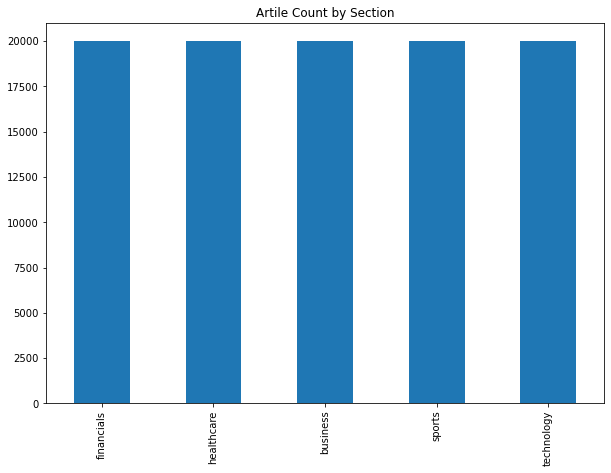

In [7]:
# Show the number of articles in each section
df['section'].value_counts()[:20].plot(kind='bar', figsize=(10,7), title='Artile Count by Section')

In [8]:
# Rename financials, business, and sports to other
df['section'] = df['section'].replace(['financials', 'business', 'sports'], 'other')
df.head()

,date,year,month,day,title,article,section,publication,word_count,char_count,sentence_count
0,2019-06-17 00:00:00,2019,Jun,17,"ECB's Coeure: If we decide to cut rates, we'd ...","BERLIN, June 17 (Reuters) - ECB board member B...",other,Reuters,133,654,4
1,2018-05-02 17:09:00,2018,May,2,You Can Trick Your Brain Into Being More Focused,If only every day could be like this. You can’...,healthcare,Vice,1810,8506,84
2,2019-06-23 00:00:00,2019,Jun,23,Hudson's Bay's chairman's buyout bid pits reta...,(Reuters) - The success of Hudson’s Bay Co Exe...,other,Reuters,890,4428,33
3,2018-12-28 00:00:00,2018,Dec,28,Wells Fargo to pay $575 million in settlement ...,NEW YORK (Reuters) - Wells Fargo & Co (WFC.N) ...,other,Reuters,405,2007,13
4,2019-05-21 00:00:00,2019,May,21,Factbox: Investments by automakers in the U.S....,(Reuters) - Major automakers have announced a ...,other,Reuters,954,4849,42


<AxesSubplot:title={'center':'Article Count by Section'}>

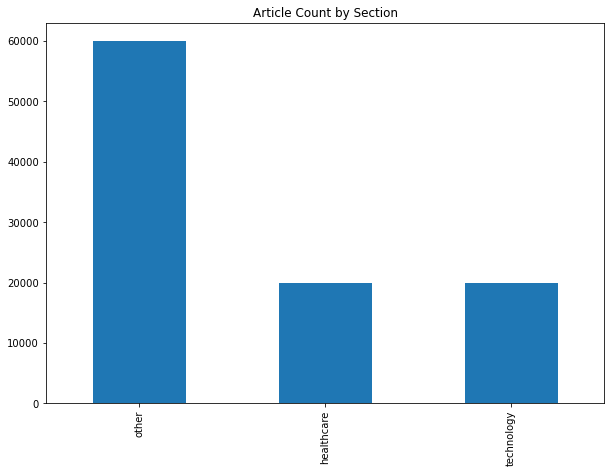

In [9]:
# Show the number of articles in each section
df['section'].value_counts()[:20].plot(kind='bar', figsize=(10,7), title='Article Count by Section')

In [10]:
# Drop random sample of 40000 articles from other section
df = df.drop(df[df['section'] == 'other'].sample(40000).index)
df.head()

,date,year,month,day,title,article,section,publication,word_count,char_count,sentence_count
1,2018-05-02 17:09:00,2018,May,2,You Can Trick Your Brain Into Being More Focused,If only every day could be like this. You can’...,healthcare,Vice,1810,8506,84
3,2018-12-28 00:00:00,2018,Dec,28,Wells Fargo to pay $575 million in settlement ...,NEW YORK (Reuters) - Wells Fargo & Co (WFC.N) ...,other,Reuters,405,2007,13
5,2019-02-05 00:00:00,2019,Feb,5,Exclusive: Britain's financial heartland unbow...,LONDON (Reuters) - Britain’s financial service...,other,Reuters,1074,4999,40
6,2016-12-18 16:40:00,2016,Dec,18,Nebraska Is Probably Regretting Letting Go of ...,"Just over two years ago, Nebraska fired head c...",other,Vice,476,2206,21
12,2019-06-20 00:00:00,2019,Jun,20,"Hungary has no evidence of Huawei threat, plan...",BUDAPEST (Reuters) - Hungary has no evidence t...,technology,Reuters,613,3139,24


In [11]:
df.shape

(60000, 11)

<AxesSubplot:title={'center':'Number of articles in each section'}>

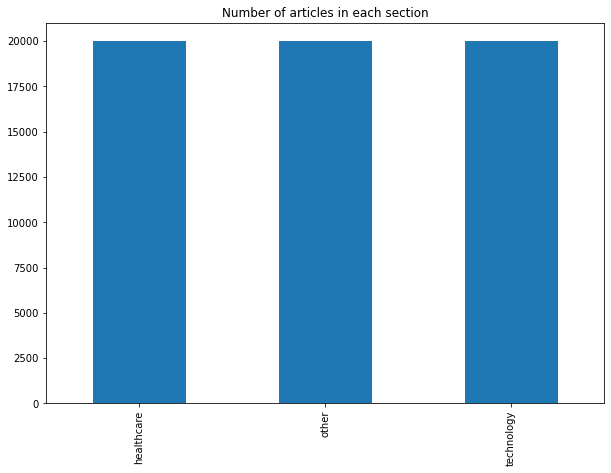

In [12]:
# Show the number of articles in each section
df['section'].value_counts()[:20].plot(kind='bar', figsize=(10,7), title='Number of articles in each section')

### Text Classification process for baseline model

1. Ensure the dataset is as balanced as possible (already done in dataset preparation)
2. Process the data (remove stop words, punctuation, etc.)
3. Create a Bag of Words feature to turn text into numbers
3. Create training and test set
4. Run some models and predictions

### Prepare data for modeling on df dataset

In [13]:
#Convert the section column into categorical values
target_section = df['section'].unique()
print(target_section)

['healthcare' 'other' 'technology']


In [14]:
# Convert the section column into numerical values
df['sectionId'] = df['section'].factorize()[0]
df.head()

,date,year,month,day,title,article,section,publication,word_count,char_count,sentence_count,sectionId
1,2018-05-02 17:09:00,2018,May,2,You Can Trick Your Brain Into Being More Focused,If only every day could be like this. You can’...,healthcare,Vice,1810,8506,84,0
3,2018-12-28 00:00:00,2018,Dec,28,Wells Fargo to pay $575 million in settlement ...,NEW YORK (Reuters) - Wells Fargo & Co (WFC.N) ...,other,Reuters,405,2007,13,1
5,2019-02-05 00:00:00,2019,Feb,5,Exclusive: Britain's financial heartland unbow...,LONDON (Reuters) - Britain’s financial service...,other,Reuters,1074,4999,40,1
6,2016-12-18 16:40:00,2016,Dec,18,Nebraska Is Probably Regretting Letting Go of ...,"Just over two years ago, Nebraska fired head c...",other,Vice,476,2206,21,1
12,2019-06-20 00:00:00,2019,Jun,20,"Hungary has no evidence of Huawei threat, plan...",BUDAPEST (Reuters) - Hungary has no evidence t...,technology,Reuters,613,3139,24,2


In [15]:
# Show the category's name and id
category_id_df = df[['section', 'sectionId']].drop_duplicates().sort_values('sectionId')
category_id_df

,section,sectionId
1,healthcare,0
3,other,1
12,technology,2


<AxesSubplot:title={'center':'Target Sections and their Corresponding Ids'}, xlabel='section,sectionId'>

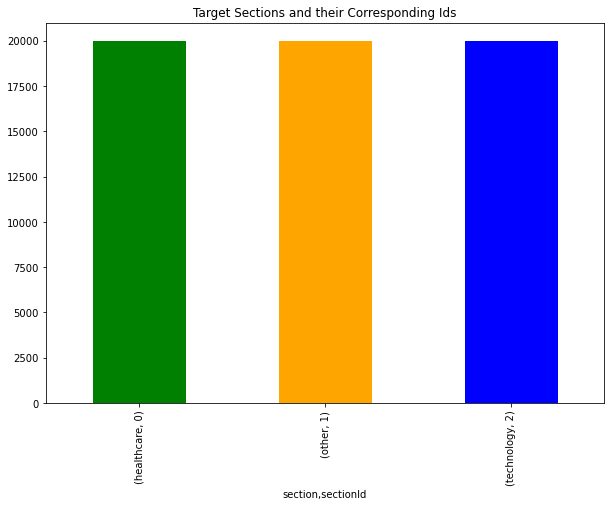

In [16]:
# Visualize the number of articles in each section
df.groupby('section').sectionId.value_counts().plot(kind='bar', \
    color= ["green", "orange", "blue", "yellow", "brown"], figsize=(10,7), title='Target Sections and their Corresponding Ids')

### Clean the article text

In [17]:
# Use NLTK to remove stopwords
stop = stopwords.words('english')

df['clean_article'] = df['article'].map(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [18]:
import re
import string
def process_text(text):
    text = str(text).lower()
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", " ", text
    )
    text = " ".join(text.split())
    return text

df['text'] = df['clean_article'].apply(process_text)

In [19]:
df.head()

,date,year,month,day,title,article,section,publication,word_count,char_count,sentence_count,sectionId,clean_article,text
1,2018-05-02 17:09:00,2018,May,2,You Can Trick Your Brain Into Being More Focused,If only every day could be like this. You can’...,healthcare,Vice,1810,8506,84,0,If every day could like this. You can’t put fi...,if every day could like this you can’t put fin...
3,2018-12-28 00:00:00,2018,Dec,28,Wells Fargo to pay $575 million in settlement ...,NEW YORK (Reuters) - Wells Fargo & Co (WFC.N) ...,other,Reuters,405,2007,13,1,NEW YORK (Reuters) - Wells Fargo & Co (WFC.N) ...,new york reuters wells fargo co wfc n pay 575 ...
5,2019-02-05 00:00:00,2019,Feb,5,Exclusive: Britain's financial heartland unbow...,LONDON (Reuters) - Britain’s financial service...,other,Reuters,1074,4999,40,1,LONDON (Reuters) - Britain’s financial service...,london reuters britain’s financial services in...
6,2016-12-18 16:40:00,2016,Dec,18,Nebraska Is Probably Regretting Letting Go of ...,"Just over two years ago, Nebraska fired head c...",other,Vice,476,2206,21,1,"Just two years ago, Nebraska fired head coach ...",just two years ago nebraska fired head coach b...
12,2019-06-20 00:00:00,2019,Jun,20,"Hungary has no evidence of Huawei threat, plan...",BUDAPEST (Reuters) - Hungary has no evidence t...,technology,Reuters,613,3139,24,2,BUDAPEST (Reuters) - Hungary evidence equipmen...,budapest reuters hungary evidence equipment ch...


### Build models and make predictions

In [20]:
# Split the data into training and test sets
target = df['sectionId']
df_train, df_test = train_test_split(df, test_size=0.20, stratify=target)

In [21]:
vec = CountVectorizer()

X_train = vec.fit_transform(df_train.text)
X_test = vec.transform(df_test.text)

y_train = df_train.sectionId
y_test = df_test.sectionId

In [ ]:
# Create a pickle file for the CountVectorizer
import pickle5 as pickle
pickle.dump(vec, open('count_vectorizer.pkl', 'wb'))

In [23]:
# What version of NLTK
import nltk
print(nltk.__version__)

3.8.1


##### Logistic Regression: F1 - .91%

In [24]:
# Train a logistic regression model
lr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/fastai/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
# Fit the model
lr.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/fastai/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial', random_state=0)

In [ ]:
# Pickle the model
filename = 'lr_021223.pkl'
pickle.dump(lr, open(filename, 'wb'))

In [26]:
# Predict the test set results
y_pred = lr.predict(X_test)

In [27]:
# Evaluate the model
print("Accuracy: ", accuracy_score(y_test, y_pred))

Accuracy:  0.9225


In [28]:
# Show precision, recall, and f1-score
print(classification_report(y_test, y_pred, target_names=df['section'].unique()))

              precision    recall  f1-score   support

  healthcare       0.94      0.94      0.94      4000
       other       0.90      0.89      0.90      4000
  technology       0.93      0.93      0.93      4000

    accuracy                           0.92     12000
   macro avg       0.92      0.92      0.92     12000
weighted avg       0.92      0.92      0.92     12000



In [29]:
# Overall F1 score
print("F1 score: ", f1_score(y_test, y_pred, average='weighted'))

F1 score:  0.922412667000533


Test sentences

0. Other: Sitting across from Jimmy Fallon on “The Tonight Show,” Paris Hilton, wearing a sparkling neon green turtleneck dress and a high ponytail, looked at a picture of a glum cartoon ape and said it “reminds me of me.” The audience laughed. It did not look like her at all.
1. Healthcare: Plans are moving forward at the US Department of Health and Human Services to prepare for the end of the nation’s Covid-19 public health emergency declaration in May.
2. As Apple looks beyond China to secure crucial supply chains strained by Covid lockdowns and threatened by rising geopolitical tension, India has emerged as an attractive potential alternative to the world’s second largest economy.

In [117]:
# Input a new article never seen by the model and make predictions using pickled model
def predict_new_text(text):
    # Load the pickled model
    model = 'lr_021223.pkl'
    vectorizer = 'vectorizer_021223.pkl'

    loaded_model = pickle.load(open(model, 'rb'))
    loaded_vec = pickle.load(open(vectorizer, 'rb'))
  
   
    text = process_text(text)
    text = loaded_vec.transform([text])
    prediction = loaded_model.predict([text])
    return prediction

In [122]:
# Predict the section of a new article
predict_new_text("The U.S. economy added 379,000 jobs in January, the Labor Department said Friday, a sharp slowdown from the previous month but still a healthy pace of hiring that should help keep the economy growing. The unemployment rate fell to 4.0%, the lowest level since 2000. The jobless rate has fallen steadily since the Great Recession, and the economy has added jobs for 100 straight months. The economy.")

ValueError: Expected 2D array, got 1D array instead:
array=[<1x161849 sparse matrix of type '<class 'numpy.int64'>'
 	with 47 stored elements in Compressed Sparse Row format>].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.